In [1]:
import numpy as np
import os
import random
import torch 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from TransUNet.networks.vit_seg_modeling import VisionTransformer
from TransUNet.networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
from dataset_function import *
from loss_functions import *
from model_training_function import *
from model_inference_function import *

In [2]:
# this function guarantees reproductivity
def seed_everything(TORCH_SEED):
	random.seed(TORCH_SEED)
	os.environ['PYTHONHASHSEED'] = str(TORCH_SEED)
	np.random.seed(TORCH_SEED)
	torch.manual_seed(TORCH_SEED)
	torch.cuda.manual_seed_all(TORCH_SEED)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

In [3]:
seed = 111
seed_everything(seed)

### Data Preprocessing

In [4]:
label_mapping = {
    0: 0,     
    1: 128,   
    2: 255    
}

In [5]:
# Function to set the seed for each worker
def seed_worker(worker_id):
    # Set seed for Python and NumPy in each worker
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [6]:
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
cases = np.arange(131)

In [8]:
train_cases, val_cases, test_cases = split_data(cases)

In [9]:
print(train_cases.shape[0])
print(val_cases.shape[0])
print(test_cases.shape[0])

91
13
27


In [10]:
train_dataset = LitsDataset(train_cases, training = True, use_joint_transforms = True)
validation_dataset = LitsDataset(val_cases, training = False, use_joint_transforms = True)
testing_dataset = LitsDataset(test_cases, training = False, use_joint_transforms = False)

In [11]:
print(f'train size: {len(train_dataset)}')
print(f'valid size: {len(validation_dataset)}')
print(f'test size: {len(testing_dataset)}')

train size: 13725
valid size: 1567
test size: 3872


In [12]:
g_train = torch.Generator()
g_train.manual_seed(seed)
g_val = torch.Generator()
g_val.manual_seed(seed + 1)
g_test = torch.Generator()
g_test.manual_seed(seed + 2)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, generator = g_train, worker_init_fn = seed_worker)
validation_loader = DataLoader(validation_dataset, batch_size = batch_size, shuffle = False, generator = g_val, worker_init_fn = seed_worker)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle = False, generator = g_test, worker_init_fn = seed_worker)

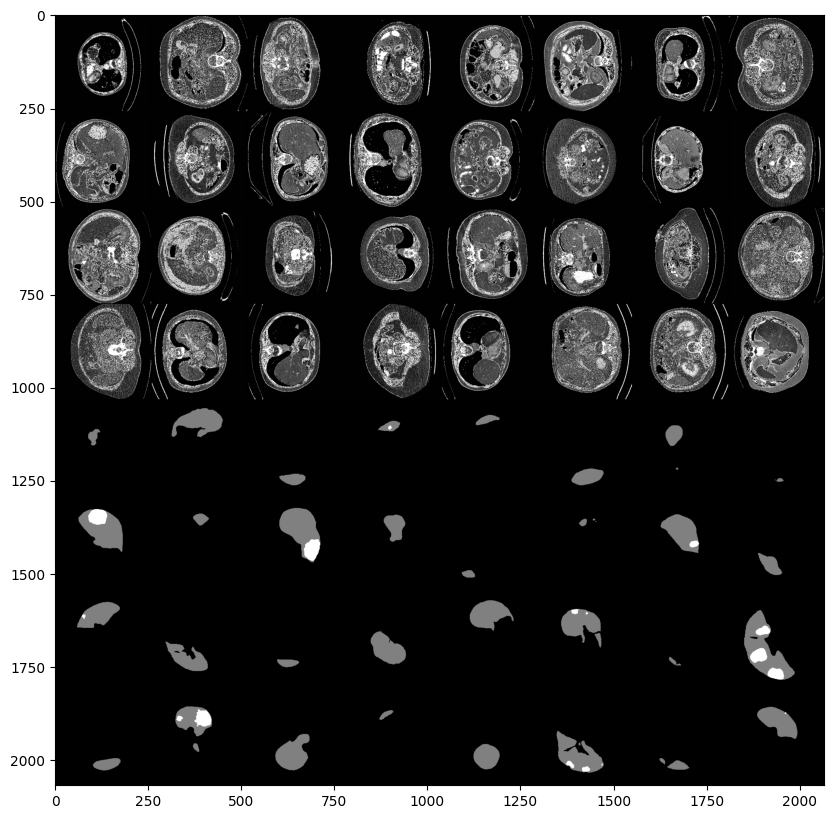

In [13]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
images = images * 255
images = images.to(torch.uint8)
labels = labels.apply_(label_mapping.get)
labels = torch.stack((labels, labels, labels), dim = 1)

grid_img = make_grid(images)
grid_label = make_grid(labels)
concat = torch.cat((grid_img, grid_label), dim = 1)

plt.figure(figsize = (10, 10))
plt.imshow(concat.permute(1, 2, 0))
plt.show()

### Model Training

In [14]:
config_vit = CONFIGS_ViT_seg["R50-ViT-B_16"]
config_vit.n_classes = 3
config_vit.n_skip = 3
model = VisionTransformer(config_vit, img_size = 256, num_classes = config_vit.n_classes).to(device)
weight = np.load('./TransUNet/R50+ViT-B_16.npz')
model.load_from(weights = weight)

load_pretrained: grid-size from 14 to 16


In [15]:
LR = 0.01
num_epochs = 80
class_weights = [0.1, 1.0, 2.0]

In [16]:
criterion = WeightedCombinedLoss(class_weights = class_weights)
optimizer = optim.Adam(model.parameters(), lr = LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.5)

In [17]:
writer = SummaryWriter('runs/transunet_weighted')
writer.add_scalar('Loss/train', 10, 0)
writer.add_scalar('Dice_1/train', 0, 0)
writer.add_scalar('Dice_2/train', 0, 0)
writer.add_scalar('Loss/valid', 10, 0)
writer.add_scalar('Dice_1/valid', 0, 0)
writer.add_scalar('Dice_2/valid', 0, 0)

In [18]:
train_model(model, train_loader, validation_loader, criterion, optimizer, scheduler, writer, num_epochs, save_dir = './model_storage/transunet_weighted', class_weights = class_weights)

Epoch 1/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [1/80], Train Loss: 0.6931, Train Dice1: 0.6491, Train Dice2: 0.3075
Validation Loss: 1.9617, Validation Dice1: 0.0007, Validation Dice2: 0.6655
Best model saved!


Epoch 2/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [2/80], Train Loss: 0.5810, Train Dice1: 0.7529, Train Dice2: 0.3018
Validation Loss: 0.5957, Validation Dice1: 0.7757, Validation Dice2: 0.1745


Epoch 3/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [3/80], Train Loss: 0.5345, Train Dice1: 0.8018, Train Dice2: 0.3823
Validation Loss: 0.6177, Validation Dice1: 0.7814, Validation Dice2: 0.3029
Best model saved!


Epoch 4/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [4/80], Train Loss: 0.5041, Train Dice1: 0.8321, Train Dice2: 0.4371
Validation Loss: 0.7868, Validation Dice1: 0.6775, Validation Dice2: 0.5970
Best model saved!


Epoch 5/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [5/80], Train Loss: 0.5434, Train Dice1: 0.7889, Train Dice2: 0.3703
Validation Loss: 0.5830, Validation Dice1: 0.7768, Validation Dice2: 0.2665


Epoch 6/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [6/80], Train Loss: 0.5108, Train Dice1: 0.8236, Train Dice2: 0.4351
Validation Loss: 0.5195, Validation Dice1: 0.8548, Validation Dice2: 0.4367


Epoch 7/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [7/80], Train Loss: 0.4807, Train Dice1: 0.8551, Train Dice2: 0.4998
Validation Loss: 0.5091, Validation Dice1: 0.8578, Validation Dice2: 0.3288


Epoch 8/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [8/80], Train Loss: 0.4617, Train Dice1: 0.8746, Train Dice2: 0.5464
Validation Loss: 0.5003, Validation Dice1: 0.8715, Validation Dice2: 0.4718


Epoch 9/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [9/80], Train Loss: 0.4499, Train Dice1: 0.8865, Train Dice2: 0.5674
Validation Loss: 0.5026, Validation Dice1: 0.8679, Validation Dice2: 0.5540
Best model saved!


Epoch 10/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [10/80], Train Loss: 0.4410, Train Dice1: 0.8939, Train Dice2: 0.5898
Validation Loss: 0.4837, Validation Dice1: 0.8762, Validation Dice2: 0.5194


Epoch 11/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [11/80], Train Loss: 0.4355, Train Dice1: 0.8976, Train Dice2: 0.6073
Validation Loss: 0.4858, Validation Dice1: 0.8858, Validation Dice2: 0.5379


Epoch 12/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [12/80], Train Loss: 0.4312, Train Dice1: 0.9036, Train Dice2: 0.6151
Validation Loss: 0.4915, Validation Dice1: 0.8930, Validation Dice2: 0.4647


Epoch 13/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [13/80], Train Loss: 0.4255, Train Dice1: 0.9070, Train Dice2: 0.6315
Validation Loss: 0.4913, Validation Dice1: 0.8862, Validation Dice2: 0.3842


Epoch 14/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [14/80], Train Loss: 0.4539, Train Dice1: 0.8598, Train Dice2: 0.6068
Validation Loss: 0.6066, Validation Dice1: 0.7312, Validation Dice2: 0.6654
Best model saved!


Epoch 15/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [15/80], Train Loss: 0.3900, Train Dice1: 0.8191, Train Dice2: 0.6758
Validation Loss: 0.3410, Validation Dice1: 0.8616, Validation Dice2: 0.6901
Best model saved!


Epoch 16/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [16/80], Train Loss: 0.3048, Train Dice1: 0.8539, Train Dice2: 0.7277
Validation Loss: 0.2864, Validation Dice1: 0.8693, Validation Dice2: 0.7091
Best model saved!


Epoch 17/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [17/80], Train Loss: 0.2504, Train Dice1: 0.8709, Train Dice2: 0.7650
Validation Loss: 0.3028, Validation Dice1: 0.8674, Validation Dice2: 0.7135
Best model saved!


Epoch 18/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [18/80], Train Loss: 0.2458, Train Dice1: 0.8701, Train Dice2: 0.7710
Validation Loss: 0.5968, Validation Dice1: 0.5435, Validation Dice2: 0.6870


Epoch 19/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [19/80], Train Loss: 0.2667, Train Dice1: 0.8655, Train Dice2: 0.7624
Validation Loss: 0.4879, Validation Dice1: 0.8119, Validation Dice2: 0.4709


Epoch 20/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [20/80], Train Loss: 0.2294, Train Dice1: 0.8776, Train Dice2: 0.7824
Validation Loss: 0.2510, Validation Dice1: 0.8831, Validation Dice2: 0.6987


Epoch 21/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [21/80], Train Loss: 0.1880, Train Dice1: 0.8940, Train Dice2: 0.8084
Validation Loss: 0.2174, Validation Dice1: 0.8879, Validation Dice2: 0.7594
Best model saved!


Epoch 22/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [22/80], Train Loss: 0.1780, Train Dice1: 0.8997, Train Dice2: 0.8166
Validation Loss: 0.2251, Validation Dice1: 0.8874, Validation Dice2: 0.7584


Epoch 23/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [23/80], Train Loss: 0.1866, Train Dice1: 0.8970, Train Dice2: 0.8111
Validation Loss: 0.2186, Validation Dice1: 0.8905, Validation Dice2: 0.7550


Epoch 24/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [24/80], Train Loss: 0.1743, Train Dice1: 0.9021, Train Dice2: 0.8166
Validation Loss: 0.2058, Validation Dice1: 0.8969, Validation Dice2: 0.7713
Best model saved!


Epoch 25/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [25/80], Train Loss: 0.1769, Train Dice1: 0.8981, Train Dice2: 0.8205
Validation Loss: 0.2368, Validation Dice1: 0.8870, Validation Dice2: 0.7722


Epoch 26/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [26/80], Train Loss: 0.1820, Train Dice1: 0.8972, Train Dice2: 0.8188
Validation Loss: 0.2518, Validation Dice1: 0.8706, Validation Dice2: 0.7624


Epoch 27/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [27/80], Train Loss: 0.1732, Train Dice1: 0.9007, Train Dice2: 0.8260
Validation Loss: 0.2166, Validation Dice1: 0.8947, Validation Dice2: 0.7554


Epoch 28/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [28/80], Train Loss: 0.1651, Train Dice1: 0.9063, Train Dice2: 0.8286
Validation Loss: 0.2283, Validation Dice1: 0.8969, Validation Dice2: 0.7342


Epoch 29/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [29/80], Train Loss: 0.1670, Train Dice1: 0.9029, Train Dice2: 0.8302
Validation Loss: 0.2841, Validation Dice1: 0.8609, Validation Dice2: 0.7032


Epoch 30/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [30/80], Train Loss: 0.1700, Train Dice1: 0.9033, Train Dice2: 0.8282
Validation Loss: 0.2064, Validation Dice1: 0.8986, Validation Dice2: 0.7583


Epoch 31/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [31/80], Train Loss: 0.1629, Train Dice1: 0.9051, Train Dice2: 0.8327
Validation Loss: 0.2251, Validation Dice1: 0.8974, Validation Dice2: 0.7365


Epoch 32/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [32/80], Train Loss: 0.1608, Train Dice1: 0.9073, Train Dice2: 0.8330
Validation Loss: 0.2195, Validation Dice1: 0.8985, Validation Dice2: 0.7450


Epoch 33/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [33/80], Train Loss: 0.1637, Train Dice1: 0.9061, Train Dice2: 0.8321
Validation Loss: 0.2102, Validation Dice1: 0.8962, Validation Dice2: 0.7684


Epoch 34/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [34/80], Train Loss: 0.1608, Train Dice1: 0.9079, Train Dice2: 0.8340
Validation Loss: 0.2353, Validation Dice1: 0.8904, Validation Dice2: 0.7643


Epoch 35/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [35/80], Train Loss: 0.1639, Train Dice1: 0.9052, Train Dice2: 0.8355
Validation Loss: 0.2186, Validation Dice1: 0.8870, Validation Dice2: 0.7496


Epoch 36/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [36/80], Train Loss: 0.1598, Train Dice1: 0.9079, Train Dice2: 0.8342
Validation Loss: 0.2260, Validation Dice1: 0.8975, Validation Dice2: 0.7370


Epoch 37/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [37/80], Train Loss: 0.1593, Train Dice1: 0.9092, Train Dice2: 0.8354
Validation Loss: 0.2188, Validation Dice1: 0.9040, Validation Dice2: 0.7453


Epoch 38/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [38/80], Train Loss: 0.1503, Train Dice1: 0.9110, Train Dice2: 0.8427
Validation Loss: 0.2165, Validation Dice1: 0.8956, Validation Dice2: 0.7573


Epoch 39/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [39/80], Train Loss: 0.1516, Train Dice1: 0.9135, Train Dice2: 0.8423
Validation Loss: 0.2081, Validation Dice1: 0.9077, Validation Dice2: 0.7879
Best model saved!


Epoch 40/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [40/80], Train Loss: 0.1623, Train Dice1: 0.9068, Train Dice2: 0.8370
Validation Loss: 0.2032, Validation Dice1: 0.8972, Validation Dice2: 0.7756


Epoch 41/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [41/80], Train Loss: 0.1423, Train Dice1: 0.9155, Train Dice2: 0.8521
Validation Loss: 0.2090, Validation Dice1: 0.9033, Validation Dice2: 0.7578


Epoch 42/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [42/80], Train Loss: 0.1377, Train Dice1: 0.9168, Train Dice2: 0.8556
Validation Loss: 0.1950, Validation Dice1: 0.9035, Validation Dice2: 0.7739


Epoch 43/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [43/80], Train Loss: 0.1334, Train Dice1: 0.9183, Train Dice2: 0.8576
Validation Loss: 0.2070, Validation Dice1: 0.8928, Validation Dice2: 0.7712


Epoch 44/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [44/80], Train Loss: 0.1338, Train Dice1: 0.9186, Train Dice2: 0.8575
Validation Loss: 0.1982, Validation Dice1: 0.8999, Validation Dice2: 0.7777


Epoch 45/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [45/80], Train Loss: 0.1327, Train Dice1: 0.9198, Train Dice2: 0.8591
Validation Loss: 0.2278, Validation Dice1: 0.8988, Validation Dice2: 0.7378


Epoch 46/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [46/80], Train Loss: 0.1321, Train Dice1: 0.9201, Train Dice2: 0.8570
Validation Loss: 0.2013, Validation Dice1: 0.9016, Validation Dice2: 0.7668


Epoch 47/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [47/80], Train Loss: 0.1361, Train Dice1: 0.9185, Train Dice2: 0.8573
Validation Loss: 0.2026, Validation Dice1: 0.9086, Validation Dice2: 0.7659


Epoch 48/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [48/80], Train Loss: 0.1265, Train Dice1: 0.9217, Train Dice2: 0.8657
Validation Loss: 0.1988, Validation Dice1: 0.9066, Validation Dice2: 0.7673


Epoch 49/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [49/80], Train Loss: 0.1268, Train Dice1: 0.9213, Train Dice2: 0.8644
Validation Loss: 0.2013, Validation Dice1: 0.9012, Validation Dice2: 0.7810


Epoch 50/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [50/80], Train Loss: 0.1294, Train Dice1: 0.9198, Train Dice2: 0.8635
Validation Loss: 0.2086, Validation Dice1: 0.9032, Validation Dice2: 0.7764


Epoch 51/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [51/80], Train Loss: 0.1356, Train Dice1: 0.9183, Train Dice2: 0.8600
Validation Loss: 0.2108, Validation Dice1: 0.9036, Validation Dice2: 0.7627


Epoch 52/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [52/80], Train Loss: 0.1263, Train Dice1: 0.9223, Train Dice2: 0.8641
Validation Loss: 0.2160, Validation Dice1: 0.8988, Validation Dice2: 0.7709


Epoch 53/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [53/80], Train Loss: 0.1307, Train Dice1: 0.9219, Train Dice2: 0.8617
Validation Loss: 0.2146, Validation Dice1: 0.9023, Validation Dice2: 0.7561


Epoch 54/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [54/80], Train Loss: 0.1238, Train Dice1: 0.9246, Train Dice2: 0.8665
Validation Loss: 0.1965, Validation Dice1: 0.9049, Validation Dice2: 0.7837


Epoch 55/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [55/80], Train Loss: 0.1252, Train Dice1: 0.9237, Train Dice2: 0.8659
Validation Loss: 0.2158, Validation Dice1: 0.9022, Validation Dice2: 0.7652


Epoch 56/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [56/80], Train Loss: 0.1217, Train Dice1: 0.9256, Train Dice2: 0.8695
Validation Loss: 0.1992, Validation Dice1: 0.9015, Validation Dice2: 0.7712


Epoch 57/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [57/80], Train Loss: 0.1217, Train Dice1: 0.9252, Train Dice2: 0.8697
Validation Loss: 0.1989, Validation Dice1: 0.9055, Validation Dice2: 0.7765


Epoch 58/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [58/80], Train Loss: 0.1284, Train Dice1: 0.9220, Train Dice2: 0.8649
Validation Loss: 0.2044, Validation Dice1: 0.9049, Validation Dice2: 0.7642


Epoch 59/80:   0%|          | 0/429 [00:00<?, ?batch/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [59/80], Train Loss: 0.1245, Train Dice1: 0.9241, Train Dice2: 0.8673
Validation Loss: 0.2048, Validation Dice1: 0.9013, Validation Dice2: 0.7707
Early Stop at 59!


In [19]:
config_vit = CONFIGS_ViT_seg["R50-ViT-B_16"]
config_vit.n_classes = 3
config_vit.n_skip = 3
best_model = VisionTransformer(config_vit, img_size = 256, num_classes = config_vit.n_classes).to(device)
checkpoint = torch.load('./model_storage/transunet_weighted/best.pth')
best_model.load_state_dict(checkpoint)
criterion = WeightedCombinedLoss(class_weights = class_weights)

In [20]:
train_dice_1, train_dice_2, train_iou_1, train_iou_2 = test_model(best_model, train_loader, criterion)

  0%|          | 0/429 [00:00<?, ?it/s]

Loss: 0.1521, Dice1: 0.9190, Dice2: 0.8505, IoU1: 0.8696, IoU2: 0.8183


In [21]:
test_dice_1, test_dice_2, test_iou_1, test_iou_2 = test_model(best_model, testing_loader, criterion)

  0%|          | 0/121 [00:00<?, ?it/s]

Loss: 0.2982, Dice1: 0.8911, Dice2: 0.7643, IoU1: 0.8346, IoU2: 0.7349


In [22]:
idx = random.randint(0, len(testing_dataset))
selected_img, selected_label = testing_dataset[idx]

In [23]:
pred = infernece(best_model, selected_img)

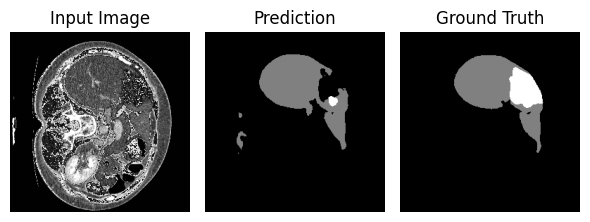

In [24]:
display_result(selected_img, pred, selected_label)